In [1]:
import sys 
import os
import pandas as pd
import random


# Add the parent directory to the path if it's not already there
if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))

In [3]:
%load_ext autoreload
%autoreload 2

In [2]:
from ddql_optimal_execution import DDQL, MarketEnvironnement, Trainer, TWAP
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

### Prepare and split data  by episodes and split train /test 

In [3]:
data=pd.read_csv("../data/BTC_ETH_15mn.csv")
data=data[["Date","Price","volume"]]
#One episode corresponds to one week of trading 

# Transformer explicitement la colonne Date en datetime
data['Date'] = pd.to_datetime(data['Date'])

# Ajouter une colonne "week" correspondant au début de semaine (lundi)
data['week'] = data['Date'].dt.to_period('W').apply(lambda r: r.start_time)

# Extraire toutes les semaines uniques
weeks = data['week'].unique()

# Mélanger aléatoirement les semaines
random.shuffle(weeks)

# Split : 2/3 pour train, 1/3 pour test
split_idx = int(len(weeks) * 2 / 3)
train_weeks = weeks[:split_idx]
test_weeks = weeks[split_idx:]

# Créer les dossiers s'ils n'existent pas
os.makedirs('../data/train', exist_ok=True)
os.makedirs('../data/test', exist_ok=True)

# Sauvegarder les fichiers par semaine
for week in weeks:
    week_data = data[data['week'] == week].drop(columns=['week'])  # on enlève la colonne week pour sauvegarder
    filename = str(week).split("T")[0]+".csv"
    if week in train_weeks:
        week_data.to_csv(os.path.join('../data/train', filename), index=False)
    else:
        week_data.to_csv(os.path.join('../data/test', filename), index=False)



/var/folders/cy/p_l7v2mn57v5jtdrn3qvp_0h0000gq/T/ipykernel_6523/1479965836.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data['week'] = data['Date'].dt.to_period('W').apply(lambda r: r.start_time)


In [3]:
QV = True  #next true, next false
Volume = False #next False, next false

In [4]:
env = MarketEnvironnement(initial_inventory=50, multi_episodes=True, QV=QV, Volume=Volume, data_path='../data/train')

In [5]:
agent = DDQL(state_size=env.state_size, initial_budget=env.initial_inventory, horizon=env.horizon)

Using cpu device


In [6]:
trainer = Trainer(agent, env, capacity=10000)

In [7]:
# Fills experience replay buffer with experiences of boundary cases
trainer.fill_exp_replay(max_steps=100)#max_steps=10000

Filling experience replay buffer: 265it [00:00, 665.62it/s]                        


In [8]:
#pretrains a DDQL agent by running random episodes, taking limit actions (sell all at the beginning or the end) and storing the experiences in an experience replay buffer
trainer.pretrain(max_steps=100, batch_size=12)

Pretraining agent: 100%|██████████| 100/100 [00:05<00:00, 17.62it/s]


In [9]:
trainer.train(max_steps=100, batch_size=128) #max_steps=1000

Training agent: 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


In [15]:
for batch in trainer.agent.dataloaders[-1]:
    target=batch[2]
    action=batch[1]
    state=batch[0]

In [26]:
from ddql_optimal_execution.environnement._data_processing import inventory_action_transformer

In [49]:

state[:,-1]=torch.tensor(inventory_action_transformer(torch.stack([state[:,-1],action],dim=1))[:,0])
state[:,-1]

tensor([-0.9500, -0.9500, -0.9500, -1.0000, -0.9500, -1.0000, -0.9500, -0.9500,
        -0.9500, -0.9500, -0.9500, -0.9500, -0.9500, -1.0000, -0.9510, -1.0000,
        -0.9500, -0.9500, -0.9850, -1.0000, -0.9500, -0.9500, -0.9500, -0.9500,
        -0.9500, -0.9500, -0.9500, -0.9500, -0.9500, -0.9500, -0.9500, -0.9500])

In [57]:
trainer.env.state.astensor

tensor([ 0.7258,  4.0000, -0.5272, 49.0000])

In [68]:
inventory_action_transformer(torch.tensor([trainer.env.state.astensor[-1],1]).unsqueeze(0))[0,0]

-0.9519999

In [65]:
torch.stack([state[:,-1],action],dim=1)[0]

tensor([-0.9500,  0.0000])

In [63]:
import torch
inventory_action_transformer(torch.stack([state[:,-1],action],dim=1)[0].unsqueeze(0))[0,0]

-1.0009499

In [10]:
def compute_last_pnl(trainer):
    #Compute pnl of last period
    inventory = trainer.env.state["inventory"]
    intra_time_steps_prices = trainer.env.historical_data[
        trainer.env.historical_data.period == trainer.env.state["period"]
    ].Price.values
    len_ts = len(intra_time_steps_prices)
    final_pnl=0
    for p1, _,_ in zip(
            intra_time_steps_prices[:-1],
            intra_time_steps_prices[1:],
            trainer.env.get_current_raw_price(),
        ):
    
        final_pnl+=(
                inventory / ( len_ts) * p1
                - trainer.env.quadratic_penalty_coefficient
                * (inventory/ ( len_ts)) ** 2
            )
    return final_pnl

In [11]:
def evaluate(test_env,trainer,n_episodes):
        #test the agent
    pnl= {'twap':[], 'ddql':[]}
    
    twap = TWAP(initial_budget=test_env.initial_inventory, horizon=test_env.horizon)

    pnl_twap = []
    pnl_ddql = []


    

    random_ep = np.random.choice(np.arange(n_episodes), size=n_episodes, replace=True)

    for ep in random_ep:
        test_env.swap_episode(ep)
        while not test_env.done:
            current_state = test_env.state.copy()
            action = twap(current_state)
            _ = test_env.step(action)
        
        initial_pnl=0
        final_pnl=compute_last_pnl(trainer)
            
        #pnl_twap.append(test_env.pnl_for_episode + [test_env.state['Price']*test_env.state['inventory'] - test_env.quadratic_penalty_coefficient*(test_env.state['inventory']/test_env.initial_inventory)**2 / test_env.horizon])
        pnl_twap.append([initial_pnl]+test_env.pnl_for_episode + [final_pnl])
        
        
        
        test_env.reset()
        
        while not test_env.done:
            current_state = test_env.state.copy()
            action = trainer.agent(current_state)
            _ = test_env.step(action)

        initial_pnl=0
        final_pnl=compute_last_pnl(trainer)
        #pnl_ddql.append(test_env.pnl_for_episode + [test_env.state['Price']*test_env.state['inventory'] - test_env.quadratic_penalty_coefficient*(test_env.state['inventory']/test_env.initial_inventory)**2 / test_env.horizon])
        pnl_ddql.append([initial_pnl]+test_env.pnl_for_episode + [final_pnl])

    pnl_ddql, pnl_twap = np.array(pnl_ddql), np.array(pnl_twap)
    pnl_ddql_sum = pnl_ddql.sum(axis=1)
    pnl_twap_sum = pnl_twap.sum(axis=1)
    
    delta_pnl = (pnl_ddql_sum - pnl_twap_sum)/ pnl_twap_sum


    GLR = - delta_pnl[delta_pnl > 0].mean()/  delta_pnl[delta_pnl < 0].mean()

    prob_win = np.bincount(delta_pnl > 0)[1] / len(delta_pnl)

    return pnl_ddql,pnl_twap,delta_pnl,GLR,prob_win

In [12]:
test_env = MarketEnvironnement(initial_inventory=500, multi_episodes=True, QV=QV, Volume=Volume, data_path='../data/train')
n_episodes = min(len(test_env.historical_data_series), 100)

In [13]:
evaluate(test_env,trainer,n_episodes)

(array([[  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,  66.16065798],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,  66.16065798],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,  66.16065798],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,  66.16065798],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,  66.16065798],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,  66.16065798],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,  66.16065798],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,  66.16065798],
        [  0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,  66.16065798],
        [  0.        ,   0.        ,   0.        ,   0.        ,
        

Using cpu device


Filling experience replay buffer: 101it [00:00, 560.34it/s]                        
Training agent: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


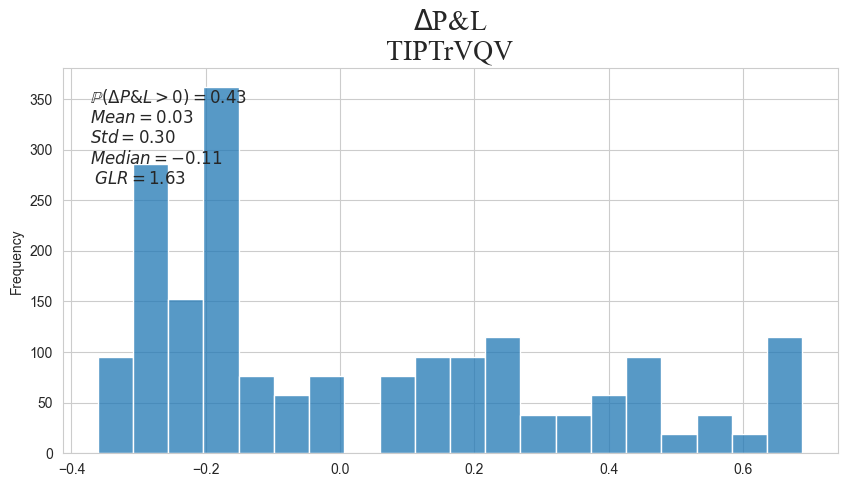

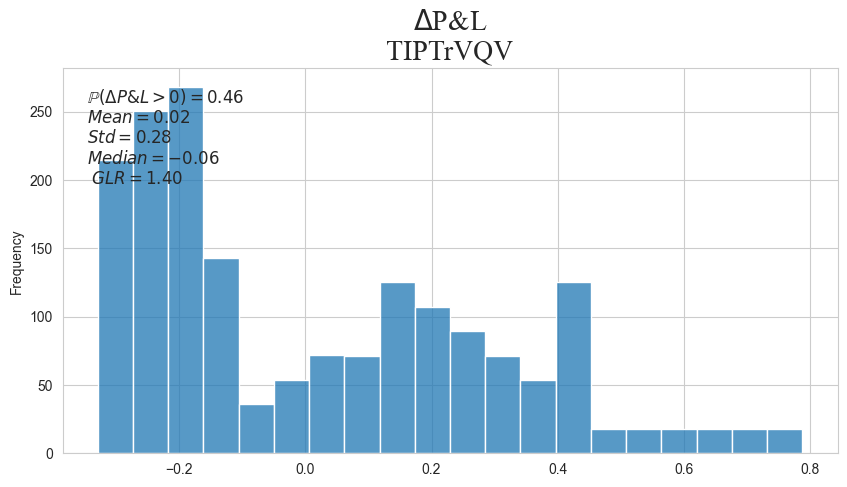

In [14]:
for QV in [True, ]:
    for Volume in [True, ]:
        env = MarketEnvironnement(initial_inventory=500, multi_episodes=True, QV=QV, Volume=Volume, data_path='../data/train', quadratic_penalty_coefficient=0)
        agent = DDQL(state_size=env.state_size, initial_budget=env.initial_inventory, horizon=env.horizon, quadratic_penalty_coefficient=0)
        trainer = Trainer(agent, env, capacity=100)
        trainer.fill_exp_replay(max_steps=100)
        trainer.pretrain(max_steps=100, batch_size=12)
        trainer.agent.greediness = 0.9
        trainer.train(max_steps=100, batch_size=12)#(max_steps=1000, batch_size=128)


        #test the agent
        for data_path in ['train',"test"]:
            test_env = MarketEnvironnement(initial_inventory=500, multi_episodes=True, QV=QV, Volume=Volume, data_path='../data/'+data_path, quadratic_penalty_coefficient=0)
            n_episodes = min(len(test_env.historical_data_series), 100)
            
            pnl_ddql,pnl_twap,delta_pnl,GLR,prob_win=evaluate(test_env,trainer,n_episodes)

            plt.figure(figsize=(10,5))
            sns.histplot(delta_pnl,  stat='frequency',bins=20)
            #change font$

            title = "\n".join([r'$\Delta$P&L', 'TIPTr' + 'V'*Volume+'QV'*QV])
            plt.title(title, fontdict={'fontfamily': 'times new roman'}, x=0.5, y=1, fontsize=20)
            x, y = plt.xlim()[0]*.9, plt.ylim()[1] * .7
            plt.text(x=x, y=y, s="\n".join([r'$\mathbb{P}(\Delta{P&L}'+r'>0 ) = {:.2f}$'.format(prob_win) , 
                        r'$Mean = {:.2f}$'.format(delta_pnl.mean()), r'$Std = {:.2f}$'.format(delta_pnl.std()), r'$Median = {:.2f}$'.format(np.median(delta_pnl)), r' $GLR = {:.2f}$'.format(GLR)]), fontsize=12, fontdict={'fontfamily': 'times new roman'})

            #save with ransparent background

            plt.savefig(title.replace("\n", "_").replace("$", "").replace("\\", "").replace("&", "n") +f'_{data_path}.png', dpi=300, bbox_inches='tight',transparent=True)
            
            plt.show()

In [ ]:
rainer

In [ ]:
sns.histplot(pnl_twap.sum(axis=1), label='twap', color='tab:blue', element='step',bins=20)
sns.histplot(pnl_ddql.sum(axis=1), label='ddql', color='tab:red',element='step', bins=20)
plt.legend()
plt.title('Distribution of PnL')
plt.xlabel('PnL')

In [ ]:
grid = {
    "QV": [True, False],
    "Volume": [True, False],

}

data = dict()

for QV in grid["QV"]:
    for Volume in grid["Volume"]:
        env = MarketEnvironnement(initial_inventory=100, multi_episodes=True, QV=QV, Volume=Volume,data_path = "../data/train")
        agent = DDQL(state_size=env.state_size, initial_budget=env.initial_inventory, horizon=env.horizon)
        trainer = Trainer(agent, env, capacity=10000)
        trainer.fill_exp_replay(max_steps=10000)
        trainer.pretrain(max_steps=1000, batch_size=128)
        trainer.train(max_steps=10, batch_size=128)#trainer.train(max_steps=10000, batch_size=128)
        env.reset()
        twap = TWAP(initial_budget=env.initial_inventory, horizon=env.horizon)
        pnl_twap = []
        pnl_ddql = []
        random_ep = np.random.choice(np.arange(len(env.historical_data_series)), 100)
        for ep in random_ep:
            print(ep)
            env.swap_episode(ep)
            _pnl_twap = [0]
            while not env.done:
                current_state = env.state.copy()
                action = twap(current_state)
                _ = env.step(action)
                print(env.state['Price'],action)
                _pnl_twap.append(env.state['Price']*action)
            
            pnl_twap.append(_pnl_twap)

            env.reset()
            _pnl_ddql = [0]
            while not env.done:
                current_state = env.state.copy()
                action = trainer.agent(current_state)
                _ = env.step(action)
                print(env.state['Price'],action)
                _pnl_ddql.append(env.state['Price']*action)
            pnl_ddql.append(_pnl_ddql)

        pnl_ddql, pnl_twap = np.array(pnl_ddql), np.array(pnl_twap)
        data[(QV, Volume)] = (pnl_ddql, pnl_twap)



In [1]:
trainer.agent.dataloaders

NameError: name 'trainer' is not defined

In [37]:
import pickle

with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [38]:
sns.set_palette('pastel')
sns.set_style('whitegrid')

In [ ]:
for i, (QV, Volume) in enumerate(data):
    pnl_ddql, pnl_twap = data[(QV, Volume)]
    confidence_level = .95
    confidence_level_2 = .99
    plt.plot(pnl_ddql.mean(axis=0), label='ddql', color='tab:blue')
    plt.fill_between(range(len(pnl_ddql.mean(axis=0))), pnl_ddql.mean(axis=0)-confidence_level_2*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), pnl_ddql.mean(axis=0)+confidence_level_2*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), alpha=.1,   color='tab:blue')

    plt.plot(pnl_twap.mean(axis=0), label='twap', color='tab:red')
    plt.fill_between(range(len(pnl_twap.mean(axis=0))), pnl_twap.mean(axis=0)-confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), pnl_twap.mean(axis=0)+confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), alpha=.1, color='tab:red')
    plt.legend()
    plt.xticks(
        #rotation=45,
        ticks=range(5), labels=[f"{i}" for i in range(5)]
    )
    plt.title(f'Profits with normalized prices (with 99% confidence interval)\n QV={QV}, Volume={Volume}')
    
    plt.ylabel('PnL')
    plt.savefig(f'pnl_QV_{QV}_Volume_{Volume}.png')
    plt.show()

In [ ]:
for key in data:
    print(key, np.mean(data[key][0].sum(axis=1))-np.mean(data[key][1].sum(axis=1)))
    #plt.hist(data[key][0].sum(axis=1), label='ddql', alpha=.5, color='tab:blue')
    #plt.axvline(np.mean(data[key][0].sum(axis=1)), color='tab:blue')
    #plt.hist(data[key][1].sum(axis=1), label='twap', alpha=.5, color='tab:red')
    #plt.axvline(np.mean(data[key][1].sum(axis=1)), color='tab:red')

    pnl_twap, pnl_ddql = data[key]

    sns.histplot(pnl_twap.sum(axis=1), label='twap', kde=True, stat='probability', element="step",color='tab:red', alpha=.5)
    sns.histplot(pnl_ddql.sum(axis=1), label='ddql', kde=True, stat='probability', element="step", color='tab:blue', alpha=.5)
    #plt.legend()
    #plt.title('')
    plt.xlabel('PnL')

    plt.legend()
    plt.title(f'Distribution of PnL \nQV={key[0]}, Volume={key[1]}, Pnl Spread = {np.mean(data[key][0].sum(axis=1))-np.mean(data[key][1].sum(axis=1)):.2f}')
    plt.savefig(f'../figs/QV_{key[0]}_Volume_{key[1]}_hists.png')
    plt.show()


In [203]:

# Draft Martial

import pandas as pd
import numpy as np

def fake_data(S : float = 100, r : float = 0.1, sigma : float = 0.2, start='2022-01-01 11:00:01', end='2022-01-01 13:00:00'):
    # Creation of the dataset output
    data = pd.DataFrame(pd.date_range(start=start, end=end,  freq = "s"), columns=['Date'])
    num_points, _ = np.shape(data)

    # Simulate a Black-Scholes trajectory
    dt = 1/252/6.5/3600 # scale of a second
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * np.random.normal(size=num_points - 1)
    log_returns = np.concatenate([[0], drift + diffusion])
    log_prices = np.cumsum(log_returns)
    prices = S * np.exp(log_prices)
    
    data["Price"] = prices
    data.set_index('Date', inplace=True)


    return data


In [7]:
for i in range(100):
    fake_data(start="2022-01-01 11:00:01", end="2022-01-01 12:00:00").to_csv(f"../data/fake_data_{i}.csv")
    fake_data(start="2022-01-01 12:00:01", end="2022-01-01 13:00:00").to_csv(f"../data/fake_data_{i+100}.csv")
    fake_data(start="2022-01-01 13:00:01", end="2022-01-01 14:00:00").to_csv(f"../data/fake_data_{i+200}.csv")